In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
from keras.optimizers import RMSprop, Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.callbacks import LearningRateScheduler
import math

from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

In [114]:
# def create_autoencoder(input_dim, latent_dim):
#     # Calculate the number of layers for the encoder and decoder based on the input dimension
#     num_layers = int(np.log2(input_dim / latent_dim))
#
#     # Create the input layer
#     input_layer = Input(shape=(input_dim,))
#
#     # Build the encoder layers
#     encoder = input_layer
#     for i in range(num_layers):
#         n_neurons = int(input_dim / (2 ** (i + 1)))
#         encoder = Dense(n_neurons, activation='relu')(encoder)
#
#     # Latent space layer
#     latent_space = Dense(latent_dim, activation='tanh', name='latent_space')(encoder)
#
#     # Build the decoder layers
#     decoder = latent_space
#     for i in range(num_layers, 0, -1):
#         n_neurons = int(input_dim / (2 ** i))
#         decoder = Dense(n_neurons, activation='relu')(decoder)
#
#     # Output layer
#     decoder_output = Dense(input_dim, activation='tanh')(decoder)
#
#     # Create the autoencoder, encoder, and decoder models
#     autoencoder = Model(inputs=input_layer, outputs=decoder_output)
#     encoder = Model(inputs=input_layer, outputs=latent_space)
#
#     encoded_input = Input(shape=(latent_dim,))
#     decoded_output = encoded_input
#     decoder_layers = autoencoder.layers[-(num_layers+1):]
#     for layer in decoder_layers:
#         decoded_output = layer(decoded_output)
#     decoder = Model(inputs=encoded_input, outputs=decoded_output)
#
#     return autoencoder, encoder, decoder

In [135]:
def create_autoencoder(input_dim, latent_dim, dropout_rate=0.1):
    # Calculate the number of layers for the encoder and decoder based on the input dimension
    num_layers = int(np.log2(input_dim / latent_dim))

    # Create the input layer
    input_layer = Input(shape=(input_dim,))

    # Build the encoder layers
    encoder = input_layer
    for i in range(num_layers):
        n_neurons = int(input_dim / (2 ** (i + 1)))
        encoder = Dense(n_neurons, activation='relu')(encoder)
        encoder = Dropout(dropout_rate)(encoder)

    # Latent space layer
    latent_space = Dense(latent_dim, activation='tanh', name='latent_space')(encoder)

    # Build the decoder layers
    decoder = latent_space
    for i in range(num_layers, 0, -1):
        n_neurons = int(input_dim / (2 ** i))
        decoder = Dense(n_neurons, activation='relu')(decoder)
        decoder = Dropout(dropout_rate)(decoder)

    # Output layer
    decoder_output = Dense(input_dim, activation='tanh')(decoder)

    # Create the autoencoder, encoder, and decoder models
    autoencoder = Model(inputs=input_layer, outputs=decoder_output)
    encoder = Model(inputs=input_layer, outputs=latent_space)

    encoded_input = Input(shape=(latent_dim,))
    decoded_output = encoded_input
    decoder_layers = autoencoder.layers[-(num_layers*2+1):]
    for layer in decoder_layers:
        decoded_output = layer(decoded_output)
    decoder = Model(inputs=encoded_input, outputs=decoded_output)

    return autoencoder, encoder, decoder

# Define a step decay function
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def exponential_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

def inverse_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate / (1 + k * epoch)
    return lrate

def cosine_annealing(epoch, T_max=50, eta_min=0.0001):
    initial_lrate = 0.001
    lrate = eta_min + 0.5 * (initial_lrate - eta_min) * (1 + np.cos(np.pi * epoch / T_max))
    return lrate

In [116]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [16]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

In [8]:
# Generate design matrices using cordex_descrite
num_designs = 1000
design_matrices = []
criteria_matrix = []
for _ in tqdm(range(num_designs)):
    opt_design, opt_cr = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=1, optimality=optimality, J_cb=J_cb, disable_bar=True)
    # opt_design, opt_cr = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, epochs=1, final_pass=False, main_bar=False)
    design_matrices.extend(opt_design)
    criteria_matrix.append(opt_cr)


design_matrices = np.array(design_matrices)

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_designs = scaler.fit_transform(design_matrices.reshape(num_designs, -1))

# Split the data into training and validation sets
train_data, val_data = train_test_split(normalized_designs, test_size=0.2, random_state=42)

100%|██████████| 1000/1000 [00:11<00:00, 88.51it/s]


In [136]:
# Define autoencoder architecture
input_dim = normalized_designs.shape[1]
latent_dim = 4

autoencoder, encoder, decoder = create_autoencoder(input_dim, latent_dim, dropout_rate=0.01)

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=RMSprop(), loss=tf.keras.losses.Huber())
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = autoencoder.fit(train_data, train_data,
                          epochs=1000,
                          batch_size=32,
                          validation_data=(val_data, val_data),
                          callbacks=[early_stopping])

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.4939 - val_loss: 0.4829
Epoch 2/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4646 - val_loss: 0.4557
Epoch 3/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4433 - val_loss: 0.4408
Epoch 4/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4298 - val_loss: 0.4299
Epoch 5/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4200 - val_loss: 0.4205
Epoch 6/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4142 - val_loss: 0.4103
Epoch 7/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4083 - val_loss: 0.4015
Epoch 8/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.4026 - val_loss: 0.3922
Epoch 9/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.3942 - val_loss: 0.3851
Epoch 10/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.3882 - val_loss: 0.3794

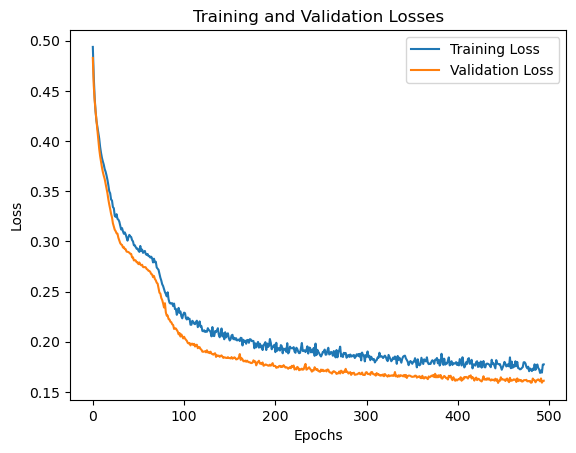

In [137]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

### Denoising Autoencoder Example

In [138]:
noise_factor = 0.1  # Adjust this value based on the desired noise level

# Add noise to the design matrices
noisy_designs = normalized_designs + noise_factor * np.random.normal(size=normalized_designs.shape)
noisy_designs = np.clip(noisy_designs, -1, 1)
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_designs, normalized_designs, test_size=0.2, random_state=42)

In [141]:
# Define autoencoder architecture
input_dim = normalized_designs.shape[1]
latent_dim = 4

autoencoder, encoder, decoder = create_autoencoder(input_dim, latent_dim, dropout_rate=0.01)

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=RMSprop(), loss=tf.keras.losses.Huber())
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = autoencoder.fit(x_train, y_train,
                          epochs=5000,
                          batch_size=32,
                          validation_data=(x_val, y_val),
                          callbacks=[early_stopping])

Epoch 1/5000
25/25 [==============================] - 1s 8ms/step - loss: 0.4961 - val_loss: 0.4892
Epoch 2/5000
25/25 [==============================] - 0s 2ms/step - loss: 0.4753 - val_loss: 0.4674
Epoch 3/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.4513 - val_loss: 0.4465
Epoch 4/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.4348 - val_loss: 0.4356
Epoch 5/5000
25/25 [==============================] - 0s 2ms/step - loss: 0.4238 - val_loss: 0.4255
Epoch 6/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.4152 - val_loss: 0.4161
Epoch 7/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.4068 - val_loss: 0.4071
Epoch 8/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.3992 - val_loss: 0.3998
Epoch 9/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.3945 - val_loss: 0.3929
Epoch 10/5000
25/25 [==============================] - 0s 1ms/step - loss: 0.3888 - val_loss: 0.3879

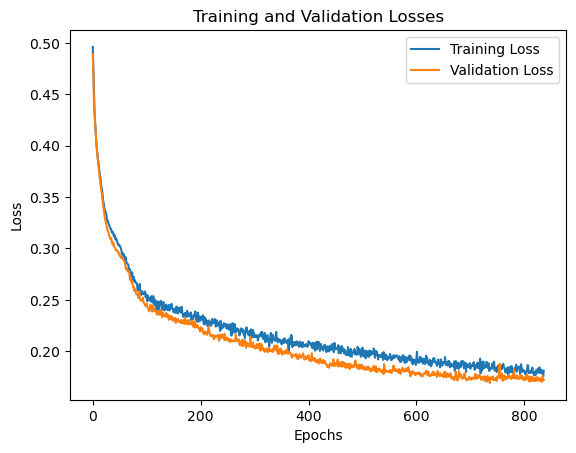

In [142]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [86]:
opt_design, opt_cr = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, epochs=1000, final_pass=True, main_bar=True)
opt_cr

  0%|          | 4/1000 [00:04<16:51,  1.02s/it]


KeyboardInterrupt: 

In [150]:
example_design, _ = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=1, optimality=optimality, J_cb=J_cb, disable_bar=True)
x = scaler.transform(example_design.reshape(1, -1))
latent_representation = encoder.predict(x)
decoded_output = decoder.predict(latent_representation).reshape(-1, sum(n_x))

1/1 [==============================] - 0s 19ms/step


In [151]:
print(latent_representation)

[[-0.99992853 -0.99999976  0.9517939   0.8349516 ]]


In [152]:
# Compute the reconstruction error (e.g., mean squared error)
reconstruction_error = np.mean((example_design - decoded_output) ** 2)
print("\nReconstruction error (MSE):", np.round(reconstruction_error,4))


Reconstruction error (MSE): 0.2703


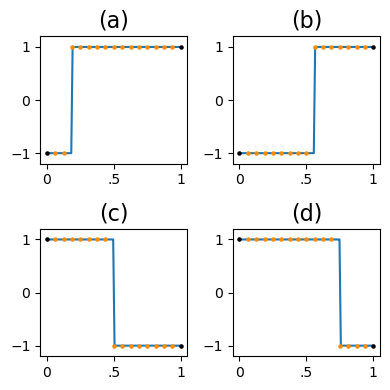

In [153]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=example_design, style='default', size=5)

In [154]:
objective_function(example_design, runs, sum(n_x), J_cb=J_cb)

9.48250220394948

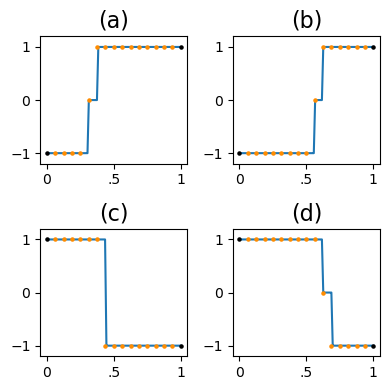

In [155]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=np.round(decoded_output), style='default', size=5)

In [156]:
objective_function(np.round(decoded_output), runs, sum(n_x), J_cb=J_cb)

10.309185560951821

In [50]:
def objective_function(X, m, n, J_cb=None, noise=0.1):
    ones = np.ones((m, 1)).reshape(-1,1)
    X = np.array(X).reshape(m, n)
    Z = np.hstack((ones, X @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M) + np.random.normal(0, noise)

In [51]:
objective_function(example_design, runs, sum(n_x), J_cb=J_cb)

NameError: name 'example_design' is not defined

In [52]:
objective_function(np.round(decoded_output), runs, sum(n_x), J_cb=J_cb)

NameError: name 'decoded_output' is not defined

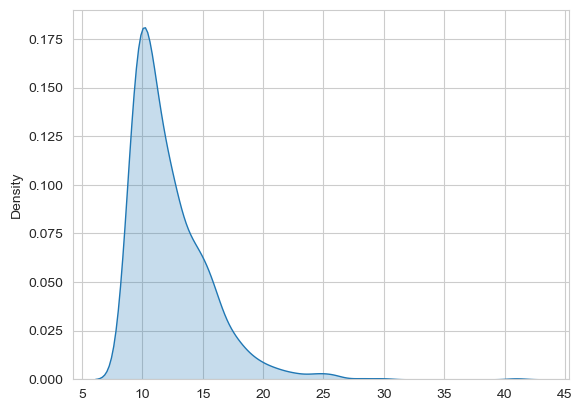

In [11]:
# plot the distribution of criteria_matrix with kde density with matplotlib
import seaborn as sns
sns.kdeplot(criteria_matrix, fill=True)
plt.show()

In [14]:
reconstructed_criterion = []
for design in design_matrices.reshape(1000, runs, sum(n_x)):
    normalized_example = scaler.transform(design.reshape(1, -1))

    # Encode and decode the example design
    encoded_example = encoder.predict(normalized_example)
    decoded_example = decoder.predict(encoded_example)

    # Inverse transform the decoded example to get the reconstructed design
    reconstructed_example = scaler.inverse_transform(decoded_example).reshape(normalized_example.shape)
    reconstructed_criterion.append(objective_function(reconstructed_example, runs, sum(n_x), J_cb=J_cb))

1/1 [==============================] - 0s 16ms/step


2023-04-15 01:28:33.414513: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 9ms/step


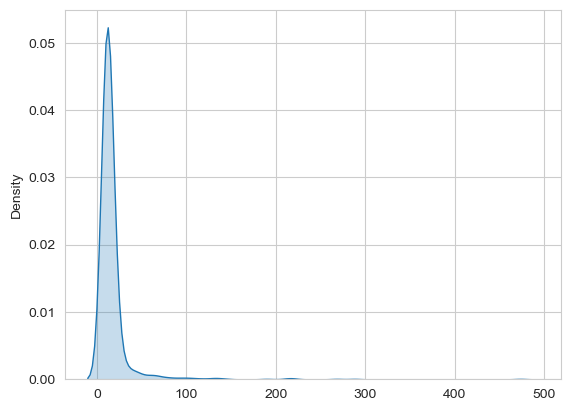

In [15]:
sns.kdeplot(reconstructed_criterion, fill=True)
plt.show()

---

In [37]:
import numpy as np
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor as SkExtraTreesRegressor
from sklearn.base import RegressorMixin
from sklearn.neural_network import MLPRegressor

from skopt.learning.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from skopt.optimizer import Optimizer
from skopt.space import Real, Integer

In [63]:
# Parameters
n_iterations = 200  # Number of iterations for the optimization process
model_update_frequency = 5  # Update the GP model every 5 iterations
random_seed = 42  # Random seed for reproducibility

# Adjust the search space to match the latent space dimension
search_space = [Real(-1., 1.) for _ in range(latent_dim)]

# Create a Gaussian Process (GP) model with a Radial Basis Function (RBF) kernel
kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
# kernel = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=random_seed)
opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=5, acq_func="LCB", random_state=random_seed)

In [64]:
def damped_oscillation(x, A, b, c, minimum):
    return A * np.exp(-b*x)*(1+np.sin((2*np.pi)/c*x)) + minimum

In [65]:
A = 0.5 # starting position
b = 0.02 # decay rate
c = 10 # period
minimum = 1e-2 # minimum value
for i in tqdm(range(n_iterations)):
    kappa = damped_oscillation(i, A, b, c, minimum)
    opt.acq_func_kwargs = {'kappa': kappa}

    latent_X = opt.ask()
    X_next = decoder.predict(np.array(latent_X).reshape(1, -1), verbose=None)
    X_next = X_next.flatten()
    f_val = objective_function(X_next, runs, sum(n_x), J_cb=J_cb, noise=0.5)
    opt.tell(latent_X, f_val)

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


In [66]:
# Convert yi list to NumPy array
yi_array = np.array(opt.yi)
positive_yi_indices = np.where(yi_array > 0)
min_positive_yi_index = positive_yi_indices[0][np.argmin(yi_array[positive_yi_indices])]
optimal_latent_X = opt.Xi[min_positive_yi_index]

# Decode the optimal point in the latent space back into the design matrix space
optimal_X = decoder.predict(np.array(optimal_latent_X).reshape(1, -1))
optimal_X = optimal_X.flatten()

optimal_matrix = np.array(optimal_X).reshape(runs, sum(n_x))
optimal_det = np.min(yi_array[positive_yi_indices])

1/1 [==============================] - 0s 30ms/step


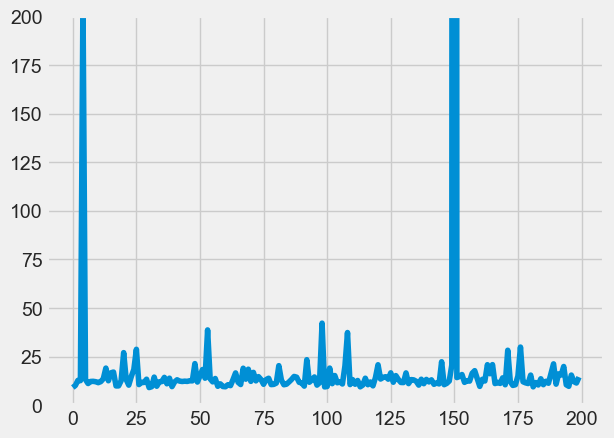

In [67]:
plt.plot(np.arange(len(yi_array[positive_yi_indices])), yi_array[positive_yi_indices])
plt.ylim(0,200)
plt.show()

In [68]:
optimal_det

9.037932964798351

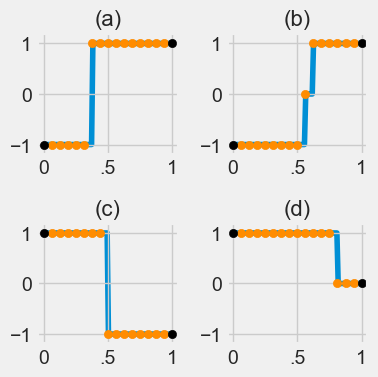

In [69]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=np.round(optimal_matrix))

In [70]:
objective_function(optimal_matrix, runs, sum(n_x), J_cb=J_cb, noise=0)

9.658116845417304